## The Final Preprocessing 

In [11]:
import pandas as pd
import holidays
import numpy as np
import matplotlib.pyplot as plt

## All Charging stations aggregated into one 

In [14]:
def convert_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        hourly_intervals = pd.date_range(start=start.floor('1h'), end=end.ceil('1h'), freq='1h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    hourly_df = pd.DataFrame(hourly_rows)

    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='1h')
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    return hourly_df

def add_features(df):
  ####################### TIMED BASED FEATURES  #######################
  df['Day_of_Week'] = df.index.dayofweek
  df['Hour_of_Day'] = df.index.hour
  df['Month_of_Year'] = df.index.month
  df['Year'] = df.index.year
  df['Day/Night'] = (df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  df['IsHoliday'] = df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################

  df['HourSin'] = np.sin(2 * np.pi * df['Hour_of_Day'] / 24)
  df['HourCos'] = np.cos(2 * np.pi * df['Hour_of_Day'] / 24)
  df['DayOfWeekSin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['DayOfWeekCos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['MonthOfYearSin'] = np.sin(2 * np.pi * df['Month_of_Year'] / 12)
  df['MonthOfYearCos'] = np.cos(2 * np.pi * df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2,
                     7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
  df['Season'] = df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  df['Energy_Consumption_1h'] = df['Energy_Consumption'].shift(1)
  df['Energy_Consumption_6h'] = df['Energy_Consumption'].shift(6)
  df['Energy_Consumption_12h'] = df['Energy_Consumption'].shift(12)
  df['Energy_Consumption_24h'] = df['Energy_Consumption'].shift(24)
  df['Energy_Consumption_1w'] = df['Energy_Consumption'].shift(24*7)
  df['Energy_Consumption_rolling'] = df['Energy_Consumption'].rolling(window=24).mean()

  return df

def filter_data(start_date, end_date, data):
    return  data[(data.index >= start_date) & (data.index <= end_date)].copy()

# Define the start and end dates
start_date = pd.to_datetime('2021-05-30')
end_date = pd.to_datetime('2023-05-30')

# Load the data
data = pd.read_csv('TestDataset/CleanedColoradoData.csv')

# Convert to quarterly data
hourly_df = convert_to_hourly(data=data)

# Add features
feature_df = add_features(hourly_df)

# Filter the data
final_df = filter_data(start_date, end_date, feature_df)

print(final_df.head(24))

# Save the quarterly data to a CSV file
final_df.to_csv('TestDataset/final_df.csv')

                     Energy_Consumption  Session_Count  Day_of_Week  \
2021-05-30 00:00:00            1.345740              1            6   
2021-05-30 01:00:00            1.345740              1            6   
2021-05-30 02:00:00            1.345740              1            6   
2021-05-30 03:00:00            1.345740              1            6   
2021-05-30 04:00:00            1.345740              1            6   
2021-05-30 05:00:00            1.345740              1            6   
2021-05-30 06:00:00            1.345740              1            6   
2021-05-30 07:00:00            1.345740              1            6   
2021-05-30 08:00:00            4.741189              6            6   
2021-05-30 09:00:00            7.253527              3            6   
2021-05-30 10:00:00            4.195423              2            6   
2021-05-30 11:00:00            3.809077              2            6   
2021-05-30 12:00:00            8.711293              3            6   
2021-0

## Plot the dataset

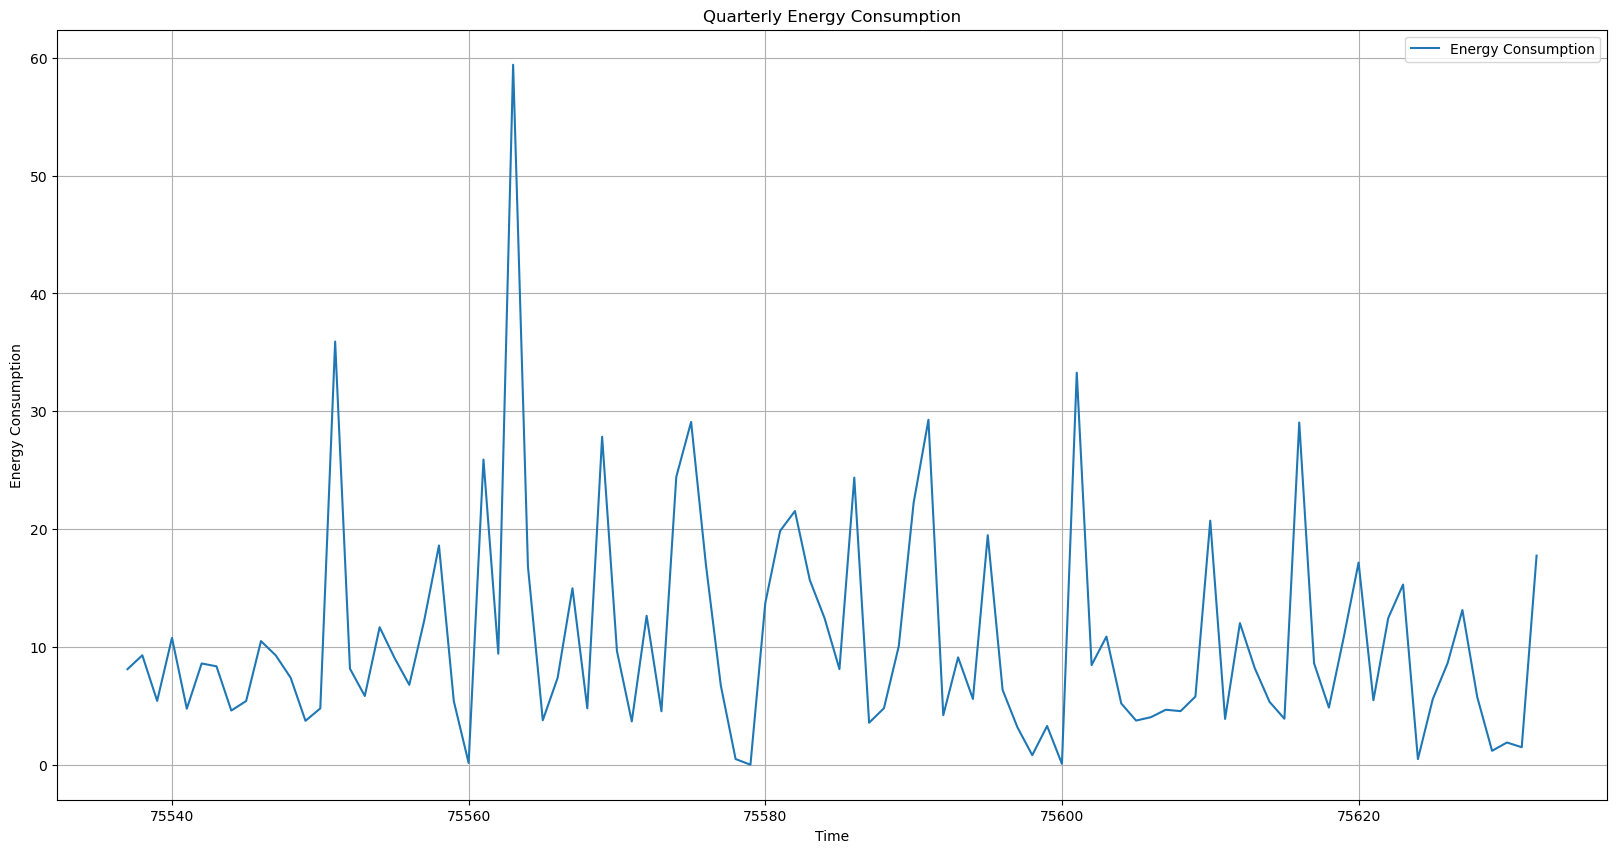

NameError: name 'final_df' is not defined

<Figure size 2000x1000 with 0 Axes>

In [10]:
# plot the the consumption for the dataset
plt.figure(figsize=(20, 10))
plt.plot(data.index[-96:], data['Energy_Consumption'][-96:], label='Energy Consumption')
plt.title('Quarterly Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid()
plt.show()

# Plot the session count for the dataset
plt.figure(figsize=(20, 10))
plt.plot(final_df.index, final_df['Session_Count'], label='Session Count')
plt.title('Quarterly Session Count')
plt.xlabel('Time')
plt.ylabel('Session Count')
plt.legend()
plt.grid()
plt.show()




## Creating Cleaned Dataset
### Already Done, see 'TestDataset/CleanedColoradoData.csv'

In [10]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")
    except ValueError:
        try:
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S")
        except ValueError:
            print(f"Could not parse date: {date_str}")
            return pd.NaT

def clean_data():
    # Load the CSV file into a pandas dataframe
    df = pd.read_csv('ColoradoData.csv')

    # Strip extra whitespace from the column names
    df.columns = [col.strip() for col in df.columns]

    # Strip extra whitespace from the date columns
    df['Start_Date___Time'] = df['Start_Date___Time'].str.strip()
    df['End_Date___Time'] = df['End_Date___Time'].str.strip()

    # Now parse the datetime columns using the parse_date function
    df['Start_DateTime'] = df['Start_Date___Time'].apply(parse_date)
    df['End_DateTime'] = df['End_Date___Time'].apply(parse_date)

    # Convert duration columns to timedelta objects
    df['Total_Duration'] = pd.to_timedelta(df['Total_Duration__hh_mm_ss_'])
    df['Charging_Time'] = pd.to_timedelta(df['Charging_Time__hh_mm_ss_'])

    # Convert Energy consumption to a numeric type (handle errors)
    df['Energy_Consumption'] = pd.to_numeric(df['Energy__kWh_'], errors='coerce')

    # Remove the columns that are no longer needed
    df = df.drop(columns=['Start_Date___Time', 'End_Date___Time', 'Total_Duration__hh_mm_ss_',
                          'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'ObjectID', 'ObjectId2', 'Start_Time_Zone', 'End_Time_Zone', 
                          'Port_Type', 'GHG_Savings__kg_', 'Gasoline_Savings__gallons_', 'City'])

    # More data cleaning
    # Remove rows with negative energy consumption
    df = df[df['Energy_Consumption'] >= 0]

    # Remove rows with missing values
    df = df.dropna()

    # Remove rows with zero charging time
    df = df[df['Charging_Time'] > pd.Timedelta(0)]

    # Remove rows with zero energy consumption
    df = df[df['Energy_Consumption'] > 0]

    # Remove rows with zero total duration
    df = df[df['Total_Duration'] > pd.Timedelta(0)]

    # Remove rows with total duration less than charging time
    df = df[df['Total_Duration'] >= df['Charging_Time']]

    # Remove duplicates
    df = df.drop_duplicates(subset=['Start_DateTime', 'Charging_Time', 'Energy_Consumption'])

    # Sort the data by the Start_DateTime column
    df = df.sort_values(by=['Start_DateTime'], ascending=True)

    # Save the cleaned data to a new CSV file
    df.to_csv('TestDataset/CleanedColoradoData.csv')

    return df

df = clean_data()